In [1]:
## Importing Libraries

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import os
import sqlite3
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
    

import re
import string
import pickle

from tqdm import tqdm
from collections import Counter

## Handling Missing Values - Model Based Imputation

In [120]:
policy_df = pd.read_csv('.data/train_Df64byy.csv')
policy_df_train = policy_df[policy_df['Health Indicator'].isna()== False]

y = policy_df_train['Health Indicator'].values
X = policy_df_train.drop(['Health Indicator'], axis=1)
X = policy_df_train.drop(['ID'], axis=1)

X['Holding_Policy_Duration'] = X['Holding_Policy_Duration'].replace(np.nan, '0', regex=True)
X['Holding_Policy_Type'] = X['Holding_Policy_Type'].replace(np.nan, 'No_policy', regex=True)

X['Holding_Policy_Type'] = X['Holding_Policy_Type'].astype(str)
X['Region_Code'] = X['Region_Code'].astype(str)
X['Reco_Policy_Cat'] = X['Reco_Policy_Cat'].astype(str)

In [121]:
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.2, stratify=y,random_state=45)
X_train.shape

(31352, 13)

In [122]:
policy_df_test = policy_df[policy_df['Health Indicator'].isna()]
#X_test = policy_df_test.drop(['ID'], axis=1)
X_test['Holding_Policy_Duration'] = X_test['Holding_Policy_Duration'].replace(np.nan, 'nan', regex=True)
X_test['Holding_Policy_Type'] = X_test['Holding_Policy_Type'].replace(np.nan, 'nan', regex=True)
X_test['Region_Code'] = X_test['Region_Code'].astype(str)
X_test['Holding_Policy_Type'] = X_test['Holding_Policy_Type'].astype(str)
X_test['Reco_Policy_Cat'] = X_test['Reco_Policy_Cat'].astype(str)
print(X_test.shape)
X_test.head()

(11691, 13)


,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
2,C5,3732,Owned,Individual,32,32,No,NaN,1.0,1.0,19,7450.0,1
6,C3,679,Owned,Individual,28,28,No,NaN,nan,nan,17,10640.0,0
9,C1,530,Owned,Joint,59,26,Yes,NaN,7.0,4.0,18,21100.8,1
12,C7,3453,Owned,Individual,66,66,No,NaN,1.0,2.0,20,17192.0,1
19,C20,973,Owned,Individual,27,27,No,NaN,nan,nan,4,8050.0,0


In [67]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['City_Code'].values) # fit has to happen only on train data

feature_names=[]

# we use the fitted CountVectorizer to convert the text to vector
X_train_city_ohe = vectorizer.transform(X_train['City_Code'].values)
X_cv_city_ohe = vectorizer.transform(X_cv['City_Code'].values)
X_test_city_ohe = vectorizer.transform(X_test['City_Code'].values)

print("After vectorizations")
print(X_train_city_ohe.shape, y_train.shape)
print(X_cv_city_ohe.shape, y_cv.shape)
print(X_test_city_ohe.shape)
print(vectorizer.get_feature_names(),len(vectorizer.get_feature_names()))
feature_names.extend(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(31352, 36) (31352,)
(7839, 36) (7839,)
(11691, 36)
['c1', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19', 'c2', 'c20', 'c21', 'c22', 'c23', 'c24', 'c25', 'c26', 'c27', 'c28', 'c29', 'c3', 'c30', 'c31', 'c32', 'c33', 'c34', 'c35', 'c36', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'] 36


In [68]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['Region_Code'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_region_ohe = vectorizer.transform(X_train['Region_Code'].values)
X_cv_region_ohe = vectorizer.transform(X_cv['Region_Code'].values)
X_test_region_ohe = vectorizer.transform(X_test['Region_Code'].values)

print("After vectorizations")
print(X_train_region_ohe.shape, y_train.shape)
print(X_cv_region_ohe.shape, y_cv.shape)
print(X_test_region_ohe.shape)
print(len(vectorizer.get_feature_names()))
feature_names.extend(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(31352, 4972) (31352,)
(7839, 4972) (7839,)
(11691, 4972)
4972


In [69]:
# creating instance of labelencoder
labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
labelencoder.fit(X_train['Accomodation_Type'])

# we use the fitted CountVectorizer to convert the text to vector
X_train_accomodation_ohe = labelencoder.transform(X_train['Accomodation_Type'].values).reshape(-1,1)
X_cv_accomodation_ohe = labelencoder.transform(X_cv['Accomodation_Type'].values).reshape(-1,1)
X_test_accomodation_ohe = labelencoder.transform(X_test['Accomodation_Type'].values).reshape(-1,1)

print("After vectorizations")
print(X_train_accomodation_ohe.shape, y_train.shape)
print(X_cv_accomodation_ohe.shape, y_cv.shape)
#print(labelencoder.get_feature_names())
feature_names.extend('Accomodation_Type')
print("="*100)

After vectorizations
(31352, 1) (31352,)
(7839, 1) (7839,)


In [70]:
# creating instance of labelencoder
labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
labelencoder.fit(X_train['Reco_Insurance_Type'])

# we use the fitted CountVectorizer to convert the text to vector
X_train_ins_type_ohe = labelencoder.transform(X_train['Reco_Insurance_Type'].values).reshape(-1,1)
X_cv_ins_type_ohe = labelencoder.transform(X_cv['Reco_Insurance_Type'].values).reshape(-1,1)
X_test_ins_type_ohe = labelencoder.transform(X_test['Reco_Insurance_Type'].values).reshape(-1,1)

print("After vectorizations")
print(X_train_ins_type_ohe.shape, y_train.shape)
print(X_cv_ins_type_ohe.shape, y_cv.shape)
#print(labelencoder.get_feature_names())
feature_names.extend('Reco_Insurance_Type')
print("="*100)

After vectorizations
(31352, 1) (31352,)
(7839, 1) (7839,)


In [71]:
# creating instance of labelencoder
labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
labelencoder.fit(X_train['Is_Spouse'])

# we use the fitted CountVectorizer to convert the text to vector
X_train_spouse_ohe = labelencoder.transform(X_train['Is_Spouse'].values).reshape(-1,1)
X_cv_spouse_ohe = labelencoder.transform(X_cv['Is_Spouse'].values).reshape(-1,1)
X_test_spouse_ohe = labelencoder.transform(X_test['Is_Spouse'].values).reshape(-1,1)

print("After vectorizations")
print(X_train_spouse_ohe.shape, y_train.shape)
print(X_cv_spouse_ohe.shape, y_cv.shape)
#print(labelencoder.get_feature_names())
feature_names.extend('Is_Spouse')
print("="*100)

After vectorizations
(31352, 1) (31352,)
(7839, 1) (7839,)


In [72]:
# creating instance of labelencoder
labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
labelencoder.fit(X_train['Response'])

# we use the fitted CountVectorizer to convert the text to vector
X_train_response_ohe = labelencoder.transform(X_train['Response'].values).reshape(-1,1)
X_cv_response_ohe = labelencoder.transform(X_cv['Response'].values).reshape(-1,1)
X_test_response_ohe = labelencoder.transform(X_test['Response'].values).reshape(-1,1)

print("After vectorizations")
print(X_train_response_ohe.shape, y_train.shape)
print(X_cv_response_ohe.shape, y_cv.shape)
#print(labelencoder.get_feature_names())
feature_names.extend('Response')
print("="*100)

After vectorizations
(31352, 1) (31352,)
(7839, 1) (7839,)


In [73]:
#token_pattern is set as the default token pattern in CountVectorizer does not capture 'single characters'
vectorizer = CountVectorizer(token_pattern='\\b\\w+\\b')

vectorizer.fit(X_train['Holding_Policy_Duration'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_hold_dur_ohe = vectorizer.transform(X_train['Holding_Policy_Duration'].values)
X_cv_hold_dur_ohe = vectorizer.transform(X_cv['Holding_Policy_Duration'].values)
X_test_hold_dur_ohe = vectorizer.transform(X_test['Holding_Policy_Duration'].values)

print("After vectorizations")
print(X_train_hold_dur_ohe.shape, y_train.shape)
print(X_cv_hold_dur_ohe.shape, y_cv.shape)
print(vectorizer.get_feature_names(),len(vectorizer.get_feature_names()))
feature_names.extend(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(31352, 15) (31352,)
(7839, 15) (7839,)
['0', '1', '10', '11', '12', '13', '14', '2', '3', '4', '5', '6', '7', '8', '9'] 15


In [74]:
vectorizer = CountVectorizer(token_pattern='\\b\\w+\\b')

vectorizer.fit(X_train['Holding_Policy_Type'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_hold_type_ohe = vectorizer.transform(X_train['Holding_Policy_Type'].values)
X_cv_hold_type_ohe = vectorizer.transform(X_cv['Holding_Policy_Type'].values)
X_test_hold_type_ohe = vectorizer.transform(X_test['Holding_Policy_Type'].values)

print("After vectorizations")
print(X_train_hold_type_ohe.shape, y_train.shape)
print(X_cv_hold_type_ohe.shape, y_cv.shape)
print(vectorizer.get_feature_names(),len(vectorizer.get_feature_names()))
feature_names.extend(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(31352, 6) (31352,)
(7839, 6) (7839,)
['0', '1', '2', '3', '4', 'no_policy'] 6


In [75]:
vectorizer = CountVectorizer(token_pattern='\\b\\w+\\b')

vectorizer.fit(X_train['Reco_Policy_Cat'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_pol_cat_ohe = vectorizer.transform(X_train['Reco_Policy_Cat'].values)
X_cv_pol_cat_ohe = vectorizer.transform(X_cv['Reco_Policy_Cat'].values)
X_test_pol_cat_ohe = vectorizer.transform(X_test['Reco_Policy_Cat'].values)

print("After vectorizations")
print(X_train_pol_cat_ohe.shape, y_train.shape)
print(X_cv_pol_cat_ohe.shape, y_cv.shape)
print(vectorizer.get_feature_names(),len(vectorizer.get_feature_names()))
feature_names.extend(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(31352, 22) (31352,)
(7839, 22) (7839,)
['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '3', '4', '5', '6', '7', '8', '9'] 22


In [76]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

normalizer.fit(X_train['Upper_Age'].values.reshape(-1,1))

X_train_upper_age_norm = normalizer.transform(X_train['Upper_Age'].values.reshape(-1,1))
X_cv_upper_age_norm = normalizer.transform(X_cv['Upper_Age'].values.reshape(-1,1))
X_test_upper_age_norm = normalizer.transform(X_test['Upper_Age'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_upper_age_norm.shape, y_train.shape)
print(X_cv_upper_age_norm.shape, y_cv.shape)
feature_names.extend('Upper_Age')
print("="*100)


After vectorizations
(31352, 1) (31352,)
(7839, 1) (7839,)


In [77]:
normalizer = Normalizer()

normalizer.fit(X_train['Lower_Age'].values.reshape(-1,1))

X_train_lower_age_norm = normalizer.transform(X_train['Lower_Age'].values.reshape(-1,1))
X_cv_lower_age_norm = normalizer.transform(X_cv['Lower_Age'].values.reshape(-1,1))
X_test_lower_age_norm = normalizer.transform(X_test['Lower_Age'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_lower_age_norm.shape, y_train.shape)
print(X_cv_lower_age_norm.shape, y_cv.shape)
feature_names.extend('Lower_Age')
print("="*100)


After vectorizations
(31352, 1) (31352,)
(7839, 1) (7839,)


In [78]:
normalizer = Normalizer()

normalizer.fit(X_train['Reco_Policy_Premium'].values.reshape(-1,1))

X_train_pol_prem_norm = normalizer.transform(X_train['Reco_Policy_Premium'].values.reshape(-1,1))
X_cv_pol_prem_norm = normalizer.transform(X_cv['Reco_Policy_Premium'].values.reshape(-1,1))
X_test_pol_prem_norm = normalizer.transform(X_test['Reco_Policy_Premium'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_pol_prem_norm.shape, y_train.shape)
print(X_cv_pol_prem_norm.shape, y_cv.shape)
feature_names.extend('Reco_Policy_Premium')
print("="*100)


After vectorizations
(31352, 1) (31352,)
(7839, 1) (7839,)


In [80]:
## Concatenating all features

from scipy.sparse import hstack
X_tr = hstack((X_train_city_ohe,X_train_region_ohe,X_train_accomodation_ohe,X_train_ins_type_ohe,X_train_spouse_ohe,X_train_response_ohe,X_train_hold_dur_ohe,X_train_hold_type_ohe,X_train_pol_cat_ohe,X_train_upper_age_norm,X_train_lower_age_norm,X_train_pol_prem_norm)).tocsr()
X_cr = hstack((X_cv_city_ohe,X_cv_region_ohe,X_cv_accomodation_ohe,X_cv_ins_type_ohe,X_cv_spouse_ohe,X_cv_response_ohe,X_cv_hold_dur_ohe,X_cv_hold_type_ohe,X_cv_pol_cat_ohe,X_cv_upper_age_norm,X_cv_lower_age_norm,X_cv_pol_prem_norm)).tocsr()
X_te = hstack((X_test_city_ohe,X_test_region_ohe,X_test_accomodation_ohe,X_test_ins_type_ohe,X_test_spouse_ohe,X_test_response_ohe,X_test_hold_dur_ohe,X_test_hold_type_ohe,X_test_pol_cat_ohe,X_test_upper_age_norm,X_test_lower_age_norm,X_test_pol_prem_norm)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape)
print("="*100)

Final Data matrix
(31352, 5058) (31352,)
(7839, 5058) (7839,)
(11691, 5058)


<h2>4.1 Appling NB on different kind of featurization</h2>

In [81]:
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    if data.shape[0]%1000 !=0:
        y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    return y_data_pred

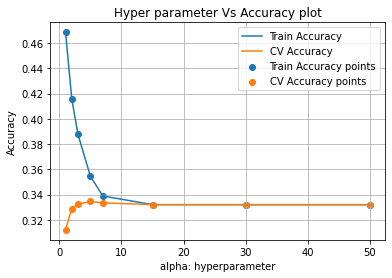

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.037014,0.001409,0.004997,0.000004,1,{'alpha': 1},0.308966,0.318534,0.308421,0.311974,0.004644,8,0.470839,0.468303,0.466702,0.468614,0.001703
1,0.036007,0.000010,0.005003,0.000007,2,{'alpha': 2},0.327241,0.333939,0.325550,0.328910,0.003622,7,0.415674,0.417301,0.415032,0.416002,0.000955
2,0.035678,0.000475,0.005331,0.000470,3,{'alpha': 3},0.333174,0.335470,0.328230,0.332291,0.003021,3,0.388402,0.387589,0.387044,0.387679,0.000558
3,0.035680,0.000473,0.005328,0.000469,5,{'alpha': 5},0.332695,0.335757,0.335120,0.334524,0.001319,1,0.354768,0.353237,0.355516,0.354507,0.000949
4,0.036682,0.000948,0.005328,0.000473,7,{'alpha': 7},0.332504,0.332887,0.335024,0.333472,0.001109,2,0.339075,0.337400,0.340159,0.338878,0.001135


In [102]:
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV


summary=[]

clf_nb = MultinomialNB()
parameters = {'alpha':[1, 2, 3, 5, 7, 15,30,50]}
clf = GridSearchCV(clf_nb, parameters, cv=3, scoring='accuracy',return_train_score=True)
clf.fit(X_tr, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_alpha'])

train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
K =  results['param_alpha']

plt.plot(K, train_auc, label='Train Accuracy')

plt.plot(K, cv_auc, label='CV Accuracy')

plt.scatter(K, train_auc, label='Train Accuracy points')
plt.scatter(K, cv_auc, label='CV Accuracy points')


plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("Accuracy")
plt.title("Hyper parameter Vs Accuracy plot")
plt.grid()
plt.show()

results.head()

#### Testing the performance of the model on test data, plotting ROC Curves

In [103]:
clf.best_params_

{'alpha': 5}

In [104]:
#here we are choosing the best_alpha based on forloop results
best_alpha = 5

In [105]:
clf = MultinomialNB(alpha = best_alpha)
clf.fit(X_tr, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(clf, X_tr)    
y_test_pred = batch_predict(clf, X_cr)

train_acc=accuracy_score(y_train, y_train_pred_result)
cv_acc=accuracy_score(y_cv, y_cv_pred_result)
print('Train Accuracy:',train_acc)
print('Test Accuracy:',cv_acc)
summary.append(['Naive Bayes',best_alpha,np.round(cv_acc,2)])

Train Accuracy: 0.3352577188058178
Test Accuracy: 0.33499170812603646


## 4.2 Apply KNN

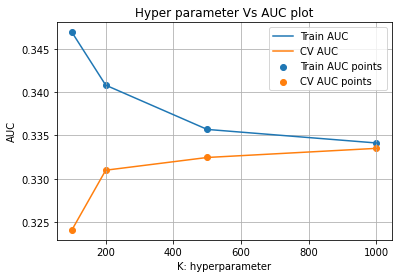

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.014343,0.001249,7.137312,0.147515,100,{'n_neighbors': 100},0.323797,0.329155,0.319330,0.324094,0.004017,4,0.346347,0.344720,0.349632,0.346900,0.002043
1,0.014002,0.000813,7.791503,0.775733,200,{'n_neighbors': 200},0.329059,0.334800,0.329091,0.330984,0.002699,3,0.340749,0.340079,0.341546,0.340792,0.000600
2,0.013670,0.000473,7.798392,0.266269,500,{'n_neighbors': 500},0.331164,0.332695,0.333493,0.332451,0.000966,2,0.336348,0.335199,0.335518,0.335688,0.000484
3,0.013668,0.000944,8.150968,0.275715,1000,{'n_neighbors': 1000},0.332313,0.333078,0.335120,0.333503,0.001185,1,0.333525,0.334960,0.333891,0.334125,0.000609


In [98]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

neigh = KNeighborsClassifier(n_jobs=-1)
parameters = {'n_neighbors':[100,200,500,1000]}
clf = RandomizedSearchCV(neigh, parameters, cv=3, scoring='accuracy',return_train_score=True)
clf.fit(X_tr, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_n_neighbors'])

train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
K =  results['param_n_neighbors']

plt.plot(K, train_auc, label='Train Accuracy')

plt.plot(K, cv_auc, label='CV Accuracy')

plt.scatter(K, train_auc, label='Train Accuracy points')
plt.scatter(K, cv_auc, label='CV Accuracy points')


plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("Accuracy")
plt.title("Hyper parameter Vs Accuracy plot")
plt.grid()
plt.show()

results.head()

#### 1.5.1.2 Testing the performance of the model on test data, plotting ROC Curves

In [107]:
#here we are choosing the best_k based on forloop results
best_k = 1000

In [108]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import accuracy_score

neigh = KNeighborsClassifier(n_neighbors=best_k, n_jobs=-1)
neigh.fit(X_tr, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(neigh, X_tr)    
y_cv_pred = batch_predict(neigh, X_cr)
y_test_pred = batch_predict(neigh, X_te)

y_train_pred_result=neigh.predict(X_tr)
y_cv_pred_result=neigh.predict(X_cr)

train_acc=accuracy_score(y_train, y_train_pred_result)
cv_acc=accuracy_score(y_cv, y_cv_pred_result)
print('Train Accuracy:',train_acc)
print('Test Accuracy:',cv_acc)

summary.append(['KNN',best_k,np.round(cv_acc,2)])

Train Accuracy: 0.3352577188058178
Test Accuracy: 0.33499170812603646


In [112]:
from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ["Model", "Hyper Parameter", "Accuracy"]

for i in range(2):
    x.add_row([summary[i][0],summary[i][1],summary[i][2]])
print(x)

+-------------+-----------------+----------+
|    Model    | Hyper Parameter | Accuracy |
+-------------+-----------------+----------+
| Naive Bayes |        5        |   0.33   |
|     KNN     |       1000      |   0.33   |
+-------------+-----------------+----------+


Since Naive Bayes has only a slightly better accuracy we will compute the missing values in Health Indiactor using KNN as it ususally performs well on imputing missing data based on the neighbouring features.

In [146]:
#Computed missing values stored
y_test_pred_result=neigh.predict(X_te)
len(y_test_pred_result)

11691

In [151]:
pred_index=X_test.index
len(X_test.index)

11691

In [152]:
y_test_pred_result

array(['X1', 'X1', 'X2', ..., 'X1', 'X1', 'X1'], dtype=object)